In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm.auto import tqdm
from collections import defaultdict

In [78]:
qml.matrix(qml.pauli.string_to_pauli_word('ZII'), wire_order=(0, 1, 2))

array([[ 1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1]])

In [79]:
class LocalVQA:
    def __init__(self, num_qubits, num_layers):
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        
    def initial_gates(self, x, z):
        
        for n in range(self.num_qubits):
            qml.RX(x[n], wires=n)
            qml.RZ(z[n], wires=n)
    
    def entangling_layer(self, x, z, start=0):
        for n in range(start, self.num_qubits+start, 2):
            i = n % self.num_qubits
            j = (n +1 ) % self.num_qubits
            qml.CZ(wires=(i, j))
        
        for n in range(self.num_qubits):
            qml.RX(x[n], wires=n)
            qml.RZ(z[n], wires=n)
    
    def all_entangling_layers(self, x, z):
        s = 0
        for xi, zi in zip(x, z):
            self.entangling_layer(xi, zi, start=s)
            s = 1-s
            
    def circuit(self, x0, z0, x, z):
        self.initial_gates(x0, z0)
        self.all_entangling_layers(x, z)
    
    def expval(self, obs):
        
        dev = qml.device('default.qubit', wires=self.num_qubits)
        @qml.qnode(dev, interface='jax')
        def expectation(x0, z0, x, z):
            self.circuit(x0, z0, x, z)
            return qml.expval(obs)
        
        return expectation
    
    def random_parameters(self):
                
        x0 = 2*np.pi*np.random.uniform(size=self.num_qubits)        
        z0 = 2*np.pi*np.random.uniform(size=self.num_qubits)
        
        x = 2*np.pi*np.random.uniform(size=(self.num_layers, self.num_qubits))
        z = 2*np.pi*np.random.uniform(size=(self.num_layers, self.num_qubits))
        
        return x0, z0, x, z
    
    def random_clifford_parameters(self):
        x0 = np.pi / 2 * np.random.choice(range(4), size=self.num_qubits, replace=True)
        z0 = np.pi / 2 * np.random.choice(range(4), size=self.num_qubits, replace=True)
        
        x = np.pi / 2 * np.random.choice(range(4), size=(self.num_layers, self.num_qubits), replace=True)
        z = np.pi / 2 * np.random.choice(range(4), size=(self.num_layers, self.num_qubits), replace=True)
        
        return x0, z0, x, z
        
    def good_random_clifford_parameters(self, obs):
        _, _, x, z = self.random_clifford_parameters()
        
        U = qml.matrix(vqa.all_entangling_layers)(x, z)
        P_evolved = qml.pauli_decompose(U.conj().T @ qml.matrix(obs, wire_order=range(self.num_qubits)) @ U)
        P_label =  qml.pauli.pauli_word_to_string(P_evolved.ops[0])
        
        x0 = []
        z0 = []
        for p in P_label:
            if p == 'I' or p == 'Z':
                x0.append(0)
                z0.append(0)
            if p == 'Y':
                x0.append(np.pi/2)
                z0.append(0)
            elif p == 'X':
                x0.append(np.pi/2)
                z0.append(np.pi/2)
            
        assert np.allclose(np.abs(self.expval(obs)(x0, z0, x, z)), 1, atol=1e-5, rtol=1e-5)
        return x0, z0, x, z
    
    def draw(self):
        qml.draw_mpl(self.circuit)(*self.random_parameters())

In [85]:
1/2**4

0.0625

In [92]:
qml.pauli.PauliWord({1: 'X'}).operation()

PauliX(wires=[1])

In [98]:
num_qubits = 6
max_num_layers = 200
num_obs = 100

expvals = {}
for num_layers in tqdm(range(1, max_num_layers+1, 20)):
    vqa = LocalVQA(num_qubits, num_layers)
    obs0 = qml.pauli.string_to_pauli_word('ZZ' + 'I' * (vqa.num_qubits -2))
    
    values = []
    for _ in range(num_obs):
        pi, pj = np.random.choice(['X', 'Y', 'Z'], size=2, replace=True)
        i = np.random.choice(range(vqa.num_qubits-1))
        obs1 = qml.pauli.PauliWord({i: pi, i+1: pj}).operation()
        
        x0, z0, x, z = vqa.good_random_clifford_parameters(obs0)
        values.append(vqa.expval(obs1)(x0, z0, x, z))
    
    expvals[int(num_layers)] = values
        

  0%|          | 0/10 [00:00<?, ?it/s]

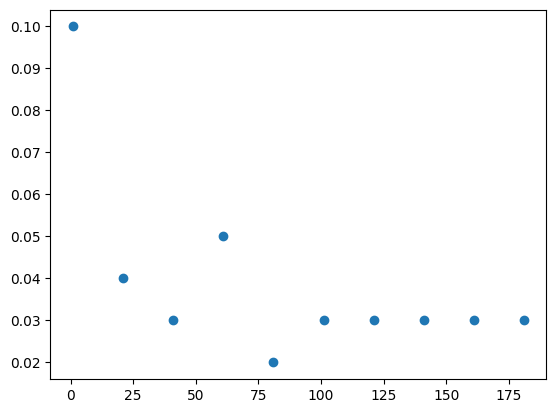

In [99]:
layers = list(expvals.keys())
stats = [np.array(np.abs(expvals[layer])).mean() for layer in layers]
plt.scatter(layers, stats)

In [101]:
2*2**-num_qubits

0.03125

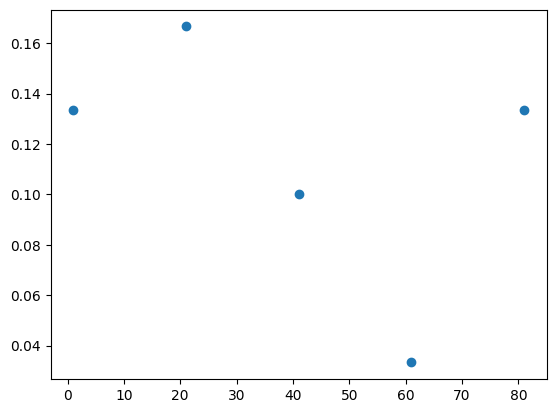

In [96]:
layers = list(expvals.keys())
stats = [np.array(np.abs(expvals[layer])).mean() for layer in layers]
plt.scatter(layers, stats)

In [106]:
def random_local_pauli(num_qubits):
    p1, p2 = np.random.choice(['X', 'Y', 'Z'], size=2, replace=True)
    i = np.random.choice(range(num_qubits-1))
    return qml.pauli.PauliWord({i: p1, i+1: p2}).operation()    

In [123]:
num_qubits = 6
num_layers = 100
vqa = LocalVQA(num_qubits, num_layers)

obs0 = random_local_pauli(vqa.num_qubits)
obs1 = random_local_pauli(vqa.num_qubits)

In [124]:
params = vqa.good_random_clifford_parameters(obs0)

In [125]:
vqa.expval(obs1)(*params)

Array(0., dtype=float32)

In [133]:
num_qubits = 8
num_layers = 100
vqa = LocalVQA(num_qubits, num_layers)

obs0 = random_local_pauli(vqa.num_qubits)
obs1 = random_local_pauli(vqa.num_qubits)

_, _, x, z = vqa.random_clifford_parameters()

In [134]:
U = qml.matrix(vqa.all_entangling_layers)(x, z)

In [135]:
P_evolved = qml.pauli_decompose(U.conj().T @ qml.matrix(obs0, wire_order=range(vqa.num_qubits)) @ U)
P_label =  qml.pauli.pauli_word_to_string(P_evolved.ops[0])

In [110]:
num_qubits = 4
max_num_layers = 100
num_obs = 1
num_samples = 100

expvals = defaultdict(dict)
for num_layers in tqdm(range(1, max_num_layers+1, 30)):
    vqa = LocalVQA(num_qubits, num_layers)
    
    values = []
    for _ in range(num_obs):
        obs0 = random_local_pauli(vqa.num_qubits)
        x0, z0, x, z = vqa.good_random_clifford_parameters(obs0)
        values0 = []
        for _ in range(num_samples):
            obs1 = random_local_pauli(vqa.num_qubits)
            val = vqa.expval(obs1)(x0, z0, x, z)
            values0.append(val)
        values.append(values0)
    
    expvals[num_qubits][int(num_layers)] = np.array(values)

  0%|          | 0/4 [00:00<?, ?it/s]

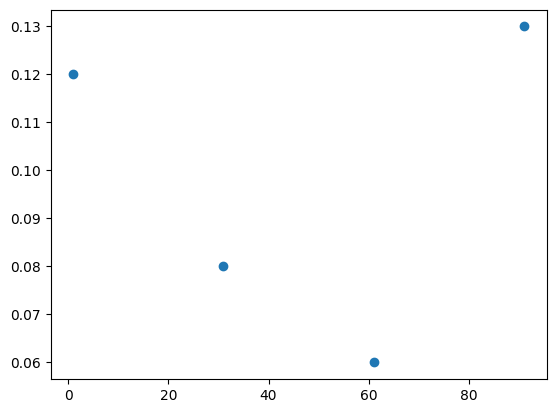

In [109]:
layers = list(expvals[num_qubits].keys())
stats = [np.abs(expvals[num_qubits][layer]).mean() for layer in layers]
plt.scatter(layers, stats)

In [105]:
num_qubits = 4
max_num_layers = 100
num_obs = 100

expvals = {}
for num_layers in tqdm(range(1, max_num_layers+1, 30)):
    vqa = LocalVQA(num_qubits, num_layers)
    obs0 = qml.pauli.string_to_pauli_word('ZZ' + 'I' * (vqa.num_qubits -2))
    
    values = []
    for _ in range(num_obs):
        pi, pj = np.random.choice(['X', 'Y', 'Z'], size=2, replace=True)
        i = np.random.choice(range(vqa.num_qubits-1))
        obs1 = qml.pauli.PauliWord({i: pi, i+1: pj}).operation()
        
        x0, z0, x, z = vqa.good_random_clifford_parameters(obs0)
        values.append(vqa.expval(obs1)(x0, z0, x, z))
    
    expvals[int(num_layers)] = values
        

  0%|          | 0/4 [00:00<?, ?it/s]

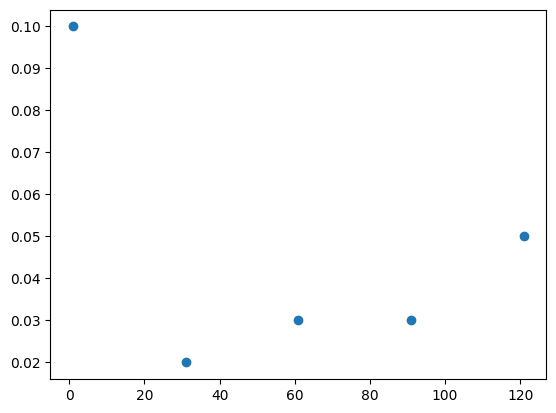

In [103]:
layers = list(expvals.keys())
stats = [np.array(np.abs(expvals[layer])).mean() for layer in layers]
plt.scatter(layers, stats)